# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
import string
from datetime import timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed
np.random.seed(42)
random.seed(42)

# Data Generation

In [3]:
def generate_campaign_data(num_records=5000):
    """
    Generates a synthetic dataset for HR recruitment campaigns with additional features.

    Parameters:
        num_records (int): Number of records to generate.

    Returns:
        pd.DataFrame: Synthetic recruitment data.
    """
    # Generate unique applicant IDs
    applicant_ids = [''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) for _ in range(num_records)]

    # Assign campaigns randomly
    campaigns = np.random.choice(['A', 'B'], size=num_records, p=[0.5, 0.5])

    # Generate application dates within the last 6 months
    base_date = pd.to_datetime('2024-04-01')
    application_dates = [base_date + pd.Timedelta(days=int(x)) for x in np.random.uniform(0, 180, num_records)]

    # Generate applicant demographics
    ages = np.random.normal(loc=30, scale=5, size=num_records).astype(int)
    ages = np.clip(ages, 18, 60)  # Age between 18 and 60

    genders = np.random.choice(['Male', 'Female', 'Other'], size=num_records, p=[0.48, 0.48, 0.04])

    education_levels = np.random.choice(['Bachelor', 'Master', 'PhD', 'Other'], size=num_records, p=[0.5, 0.3, 0.15, 0.05])

    # Simulate application completion based on campaign
    # Campaign B not only affects interview and hire rates but also application completion
    application_completion_rates = {'A': 0.95, 'B': 0.97}
    application_completed = [np.random.binomial(1, application_completion_rates[campaign]) for campaign in campaigns]

    # Simulate application quality affecting interview and hire rates
    # Higher education and age might correlate with higher hire rates
    # Introduce some correlation
    education_effect = {'Bachelor': 1.0, 'Master': 1.2, 'PhD': 1.5, 'Other': 0.8}
    age_effect = lambda age: 1 + (age - 30) * 0.01  # Slight increase per year from age 30

    base_interview_rate = {'A': 0.1, 'B': 0.12}
    base_hire_rate = {'A': 0.05, 'B': 0.06}

    interviews = []
    hires = []

    for i in range(num_records):
        campaign = campaigns[i]
        if_completed = application_completed[i]
        if not if_completed:
            interviews.append(0)
            hires.append(0)
            continue
        # Adjust rates based on education and age
        adj_interview_rate = base_interview_rate[campaign] * education_effect[education_levels[i]] * age_effect(ages[i])
        adj_interview_rate = min(adj_interview_rate, 0.3)  # Cap to avoid unrealistic rates
        interview = np.random.binomial(1, adj_interview_rate)
        interviews.append(interview)
        if interview:
            adj_hire_rate = base_hire_rate[campaign] * education_effect[education_levels[i]] * age_effect(ages[i])
            adj_hire_rate = min(adj_hire_rate, 0.2)
            hire = np.random.binomial(1, adj_hire_rate)
            hires.append(hire)
        else:
            hires.append(0)

    # Compile the dataset
    data = pd.DataFrame({
        'ApplicantID': applicant_ids,
        'Campaign': campaigns,
        'ApplicationDate': application_dates,
        'Age': ages,
        'Gender': genders,
        'EducationLevel': education_levels,
        'ApplicationCompleted': application_completed,
        'Interviewed': interviews,
        'Hired': hires
    })

    return data

In [4]:
# Generate the dataset
df = generate_campaign_data(num_records=5000)

# Display first few rows
print("Sample of Generated Data:")
display(df.head())

Sample of Generated Data:


,ApplicantID,Campaign,ApplicationDate,Age,Gender,EducationLevel,ApplicationCompleted,Interviewed,Hired
0,XAJI0Y6D,A,2024-06-10,22,Male,Master,1,0,0
1,PBHSAHXT,B,2024-06-25,24,Male,Bachelor,1,0,0
2,HV3A3ZMF,B,2024-09-01,31,Female,Master,1,0,0
3,8MDD4V30,B,2024-06-01,24,Female,PhD,1,1,0
4,T9NT3W5U,A,2024-09-04,35,Male,Bachelor,1,0,0


In [5]:
# Print shapes
print("Shape of Generated Data:")
print(df.shape)

Shape of Generated Data:
(5000, 9)


# Power Analysis

In [6]:
def perform_power_analysis(effect_size, alpha=0.05, power=0.8):
    """
    Performs power analysis to determine the required sample size.

    Parameters:
        effect_size (float): The difference in proportions to detect.
        alpha (float): Significance level.
        power (float): Desired statistical power.

    Returns:
        int: Required sample size per group.
    """
    analysis = NormalIndPower()
    sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)
    return int(np.ceil(sample_size))

In [7]:
# We want to detect a 2% difference in hire rates
# Calculate effect size using proportion difference
effect_size = proportion_effectsize(0.05, 0.07)  # From initial script: 5% vs 7%
required_sample_size = perform_power_analysis(effect_size)
print(f"Power Analysis:\nTo detect a 2% difference in hire rates with 80% power and 5% alpha, "
      f"each group requires approximately {required_sample_size} applicants.")

Power Analysis:
To detect a 2% difference in hire rates with 80% power and 5% alpha, each group requires approximately 2199 applicants.


In [8]:
# Define parameters
effect_size = proportion_effectsize(0.05, 0.07)  # Hire rates: 5% vs 7%
alpha = 0.05
sample_size_per_group = df.shape[0] / 2

# Initialize power analysis object
analysis = NormalIndPower()

# Calculate achieved power
achieved_power = analysis.power(effect_size=effect_size, nobs1=sample_size_per_group, alpha=alpha, ratio=1)

print(f"Achieved Power with {sample_size_per_group} applicants per group: {achieved_power:.4f}")

Achieved Power with 2500.0 applicants per group: 0.8479


# Data Exploration

In [9]:
# Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())

Missing Values in Each Column:
ApplicantID             0
Campaign                0
ApplicationDate         0
Age                     0
Gender                  0
EducationLevel          0
ApplicationCompleted    0
Interviewed             0
Hired                   0
dtype: int64


In [10]:
# Convert categorical variables to category data types
categorical_cols = ['Campaign', 'Gender', 'EducationLevel', 'ApplicationCompleted', 'Interviewed', 'Hired']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Check data types
print("Data Types After Conversion:")
print(df.dtypes)

Data Types After Conversion:
ApplicantID                     object
Campaign                      category
ApplicationDate         datetime64[ns]
Age                              int64
Gender                        category
EducationLevel                category
ApplicationCompleted          category
Interviewed                   category
Hired                         category
dtype: object


In [11]:
# Extract month from ApplicationDate
df['ApplicationMonth'] = df['ApplicationDate'].dt.to_period('M').astype(str)
df['ApplicationMonth'] = df['ApplicationMonth'].astype('category')
categorical_cols.append('ApplicationMonth')  # Include in categorical variables

# Check data types
print("Data Types After Conversion:")
print(df.dtypes)

Data Types After Conversion:
ApplicantID                     object
Campaign                      category
ApplicationDate         datetime64[ns]
Age                              int64
Gender                        category
EducationLevel                category
ApplicationCompleted          category
Interviewed                   category
Hired                         category
ApplicationMonth              category
dtype: object


In [12]:
# Separate numeric and categorical variables
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [13]:
# Summary statistics for numeric variables
print("Summary Statistics for Numeric Variables:")
display(df[numeric_cols].describe())

Summary Statistics for Numeric Variables:


,Age
count,5000.000000
mean,29.513600
std,4.874768
min,18.000000
25%,26.000000
50%,29.000000
75%,33.000000
max,46.000000


In [14]:
# Summary statistics for categorical variables
print("Summary Statistics for Categorical Variables:")
display(df[categorical_cols].describe())

Summary Statistics for Categorical Variables:


,Campaign,Gender,EducationLevel,ApplicationCompleted,Interviewed,Hired,ApplicationMonth
count,5000,5000,5000,5000,5000,5000,5000
unique,2,3,4,2,2,2,6
top,A,Female,Bachelor,1,0,0,2024-05
freq,2500,2477,2458,4817,4404,4972,896


# Descriptive Statistics

In [15]:
# Convert to binary integers
df['Hired'] = df['Hired'].astype('int')
df['Interviewed'] = df['Interviewed'].astype('int')
df['ApplicationCompleted'] = df['ApplicationCompleted'].astype('int')

# Conversion rates
conversion_rates = df.groupby('Campaign')['Hired'].agg(['count', 'sum']).rename(columns={'sum': 'HiredCount', 'count': 'TotalApplicants'})
conversion_rates['HireRate'] = conversion_rates['HiredCount'] / conversion_rates['TotalApplicants']
print("Conversion Rates by Campaign:")
display(conversion_rates)

# Interview rates
interview_rates = df.groupby('Campaign')['Interviewed'].agg(['count', 'sum']).rename(columns={'sum': 'InterviewedCount', 'count': 'TotalApplicants'})
interview_rates['InterviewRate'] = interview_rates['InterviewedCount'] / interview_rates['TotalApplicants']
print("\nInterview Rates by Campaign:")
display(interview_rates)

# Application completion rates
application_completion = df.groupby('Campaign')['ApplicationCompleted'].agg(['count', 'sum']).rename(columns={'sum': 'CompletedCount', 'count': 'TotalApplicants'})
application_completion['CompletionRate'] = application_completion['CompletedCount'] / application_completion['TotalApplicants']
print("\nApplication Completion Rates by Campaign:")
display(application_completion)

Conversion Rates by Campaign:


,TotalApplicants,HiredCount,HireRate
Campaign,,,
A,2500,13,0.0052
B,2500,15,0.0060



Interview Rates by Campaign:


,TotalApplicants,InterviewedCount,InterviewRate
Campaign,,,
A,2500,250,0.1000
B,2500,346,0.1384



Application Completion Rates by Campaign:


,TotalApplicants,CompletedCount,CompletionRate
Campaign,,,
A,2500,2379,0.9516
B,2500,2438,0.9752


# Hypothesis Testing

In [16]:
# Chi-Squared Test for Hire Rates
hire_A = conversion_rates.loc['A', 'HiredCount']
total_A = conversion_rates.loc['A', 'TotalApplicants']

hire_B = conversion_rates.loc['B', 'HiredCount']
total_B = conversion_rates.loc['B', 'TotalApplicants']

contingency_table_hire = np.array([
    [hire_A, total_A - hire_A],
    [hire_B, total_B - hire_B]
])

chi2_hire, p_hire, dof_hire, expected_hire = stats.chi2_contingency(contingency_table_hire)
print("Chi-Squared Test for Hire Rates:")
print(f"Chi2 Statistic: {chi2_hire:.4f}, p-value: {p_hire:.4f}, Degrees of Freedom: {dof_hire}")
print("Expected Frequencies:")
print(expected_hire)

Chi-Squared Test for Hire Rates:
Chi2 Statistic: 0.0359, p-value: 0.8497, Degrees of Freedom: 1
Expected Frequencies:
[[  14. 2486.]
 [  14. 2486.]]


In [17]:
# Fisher's Exact Test
if (expected_hire < 15).any():
    fisher_hire, p_fisher_hire = stats.fisher_exact(contingency_table_hire)
    print(f"Fisher's Exact Test p-value: {p_fisher_hire:.4f}")
    p_hire_final = p_fisher_hire
else:
    p_hire_final = p_hire

# Interpretation
alpha = 0.05
if p_hire_final < alpha:
    print("Result: Reject the null hypothesis. Significant difference in hire rates between Campaign A and B.")
else:
    print("Result: Fail to reject the null hypothesis. No significant difference in hire rates between Campaign A and B.")

Fisher's Exact Test p-value: 0.8501
Result: Fail to reject the null hypothesis. No significant difference in hire rates between Campaign A and B.


# Logistic Regression

In [18]:
# Encode categorical variables
df_reg = df.copy()
df_reg['Campaign'] = df_reg['Campaign'].cat.codes  # A=0, B=1
df_reg['Gender'] = df_reg['Gender'].cat.codes
df_reg['EducationLevel'] = df_reg['EducationLevel'].cat.codes
df_reg['ApplicationCompleted'] = df_reg['ApplicationCompleted'].astype(int)
df_reg['Interviewed'] = df_reg['Interviewed'].astype(int)

# Define the formula
formula = 'Hired ~ Campaign + Age + Gender + EducationLevel + ApplicationCompleted + Interviewed'

In [19]:
# Fit the logistic regression model
model = smf.logit(formula=formula, data=df_reg).fit()
print("Logistic Regression Results:")
print(model.summary())

         Current function value: 0.022194
         Iterations: 35
Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:                  Hired   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4993
Method:                           MLE   Df Model:                            6
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.3589
Time:                        01:53:37   Log-Likelihood:                -110.97
converged:                      False   LL-Null:                       -173.10
Covariance Type:            nonrobust   LLR p-value:                 2.072e-24
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -22.8362   2737.893     -0.008      0.993   -5389.008    5343.336
Campai

In [20]:
# Interpretation of Campaign coefficient
campaign_coef = model.params['Campaign']
campaign_p = model.pvalues['Campaign']
print(f"Campaign Coefficient: {campaign_coef:.4f}, p-value: {campaign_p:.4f}")
if campaign_p < alpha:
    print("Campaign has a statistically significant effect on hire rates after controlling for other variables.")
else:
    print("Campaign does not have a statistically significant effect on hire rates after controlling for other variables.")

Campaign Coefficient: -0.1479, p-value: 0.7058
Campaign does not have a statistically significant effect on hire rates after controlling for other variables.


# Power Analysis Confirmation

In [21]:
# Compare required sample size with actual
print(f"Actual sample size per group: {total_A}, {total_B}")
print(f"Required sample size per group for 80% power: {required_sample_size}")

if total_A >= required_sample_size and total_B >= required_sample_size:
    print("The current sample size is sufficient to detect the desired effect size with 80% power.")
else:
    print("The current sample size may be insufficient to detect the desired effect size with 80% power.")

Actual sample size per group: 2500, 2500
Required sample size per group for 80% power: 2199
The current sample size is sufficient to detect the desired effect size with 80% power.


# Segmentation Analysis

In [22]:
# Analyze hire rates by Education Level within each Campaign
segmentation = df.groupby(['Campaign', 'EducationLevel'])['Hired'].agg(['count', 'sum']).reset_index()
segmentation['HireRate'] = segmentation['sum'] / segmentation['count']
print("Hire Rates by Campaign and Education Level:")
display(segmentation)

Hire Rates by Campaign and Education Level:


,Campaign,EducationLevel,count,sum,HireRate
0,A,Bachelor,1241,4,0.003223
1,A,Master,760,4,0.005263
2,A,Other,139,0,0.000000
3,A,PhD,360,5,0.013889
4,B,Bachelor,1217,5,0.004108
5,B,Master,787,6,0.007624
6,B,Other,126,1,0.007937
7,B,PhD,370,3,0.008108


In [23]:
# Statistical test within segments
for edu in df['EducationLevel'].unique():
    subset = df[df['EducationLevel'] == edu]
    hire_A_seg = subset[subset['Campaign'] == 'A']['Hired'].sum()
    total_A_seg = subset[subset['Campaign'] == 'A']['Hired'].count()
    hire_B_seg = subset[subset['Campaign'] == 'B']['Hired'].sum()
    total_B_seg = subset[subset['Campaign'] == 'B']['Hired'].count()

    contingency_seg = np.array([
        [hire_A_seg, total_A_seg - hire_A_seg],
        [hire_B_seg, total_B_seg - hire_B_seg]
    ])

    chi2_seg, p_seg, dof_seg, expected_seg = stats.chi2_contingency(contingency_seg)

    print(f"\nChi-Squared Test for Hire Rates within Education Level: {edu}")
    print(f"Chi2: {chi2_seg:.4f}, p-value: {p_seg:.4f}")
    if p_seg < alpha:
        print("Significant difference in hire rates between Campaign A and B for this education level.")
    else:
        print("No significant difference in hire rates between Campaign A and B for this education level.")


Chi-Squared Test for Hire Rates within Education Level: Master
Chi2: 0.0686, p-value: 0.7934
No significant difference in hire rates between Campaign A and B for this education level.

Chi-Squared Test for Hire Rates within Education Level: Bachelor
Chi2: 0.0009, p-value: 0.9766
No significant difference in hire rates between Campaign A and B for this education level.

Chi-Squared Test for Hire Rates within Education Level: PhD
Chi2: 0.1556, p-value: 0.6932
No significant difference in hire rates between Campaign A and B for this education level.

Chi-Squared Test for Hire Rates within Education Level: Other
Chi2: 0.0024, p-value: 0.9608
No significant difference in hire rates between Campaign A and B for this education level.


# Time Series Analysis

In [24]:
# Aggregate hire rates by month and campaign
time_series = df.groupby(['ApplicationMonth', 'Campaign'])['Hired'].agg(['count', 'sum']).reset_index()
time_series['HireRate'] = time_series['sum'] / time_series['count']

# Pivot for plotting
time_pivot = time_series.pivot(index='ApplicationMonth', columns='Campaign', values='HireRate').fillna(0)

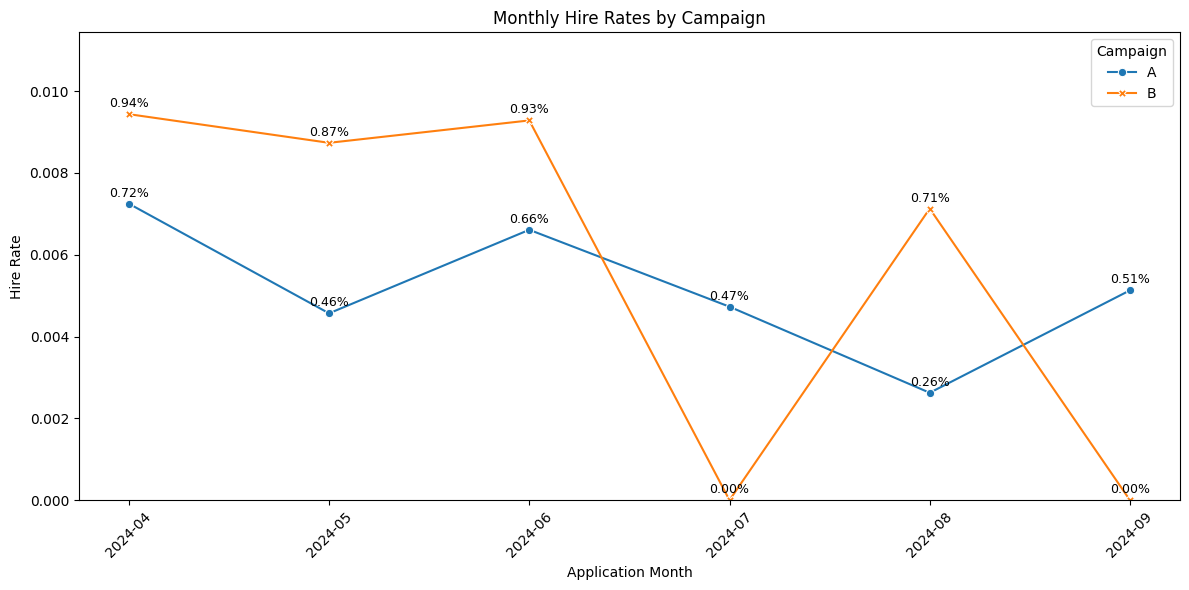

In [25]:
# Plot hire rates over time
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=time_pivot, markers=True, dashes=False)

plt.title('Monthly Hire Rates by Campaign')
plt.ylabel('Hire Rate')
plt.xlabel('Application Month')
plt.ylim(0, time_pivot.max().max() + 0.002)

# Annotate data points with hire rates
for x in time_pivot.index:
    for campaign in time_pivot.columns:
        rate = time_pivot.loc[x, campaign]
        plt.text(x=x, y=rate + 0.0001, s=f"{rate:.2%}", ha='center', va='bottom', fontsize=9)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Campaign')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization

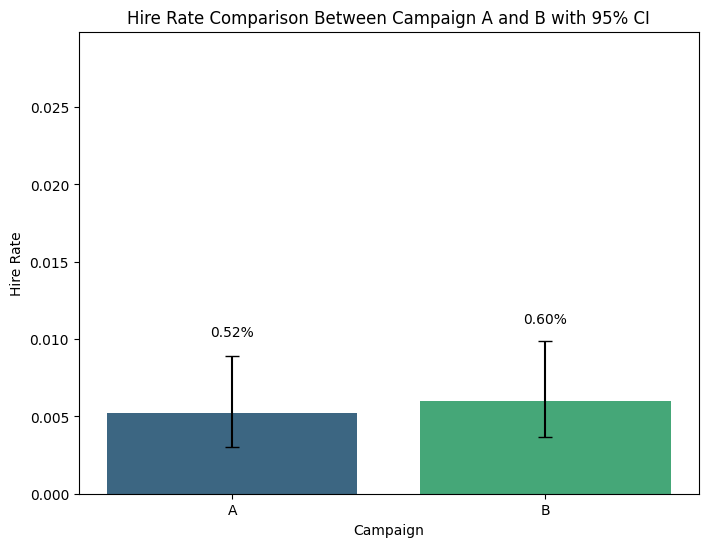

In [26]:
import statsmodels.stats.api as sms

# Hire Rate comparison with confidence intervals
# Function to calculate confidence intervals
def compute_confidence_interval(success, n, confidence=0.95):
    proportion = success / n
    ci_low, ci_upp = sms.proportion_confint(success, n, alpha=1-confidence, method='wilson')
    return ci_low, ci_upp

conversion_rates['CI_Lower'], conversion_rates['CI_Upper'] = zip(*conversion_rates.apply(lambda row: compute_confidence_interval(row['HiredCount'], row['TotalApplicants']), axis=1))

plt.figure(figsize=(8,6))
sns.barplot(x=conversion_rates.index, y='HireRate', data=conversion_rates, palette='viridis', ci=None)
plt.title('Hire Rate Comparison Between Campaign A and B with 95% CI')
plt.ylabel('Hire Rate')
plt.xlabel('Campaign')
plt.ylim(0, max(conversion_rates['CI_Upper']) + 0.02)
for idx, row in conversion_rates.iterrows():
    plt.errorbar(x=idx, y=row['HireRate'], yerr=[[row['HireRate'] - row['CI_Lower']], [row['CI_Upper'] - row['HireRate']]], fmt='none', c='black', capsize=5)
    plt.text(idx, row['HireRate'] + 0.005, f"{row['HireRate']:.2%}", ha='center')
plt.show()

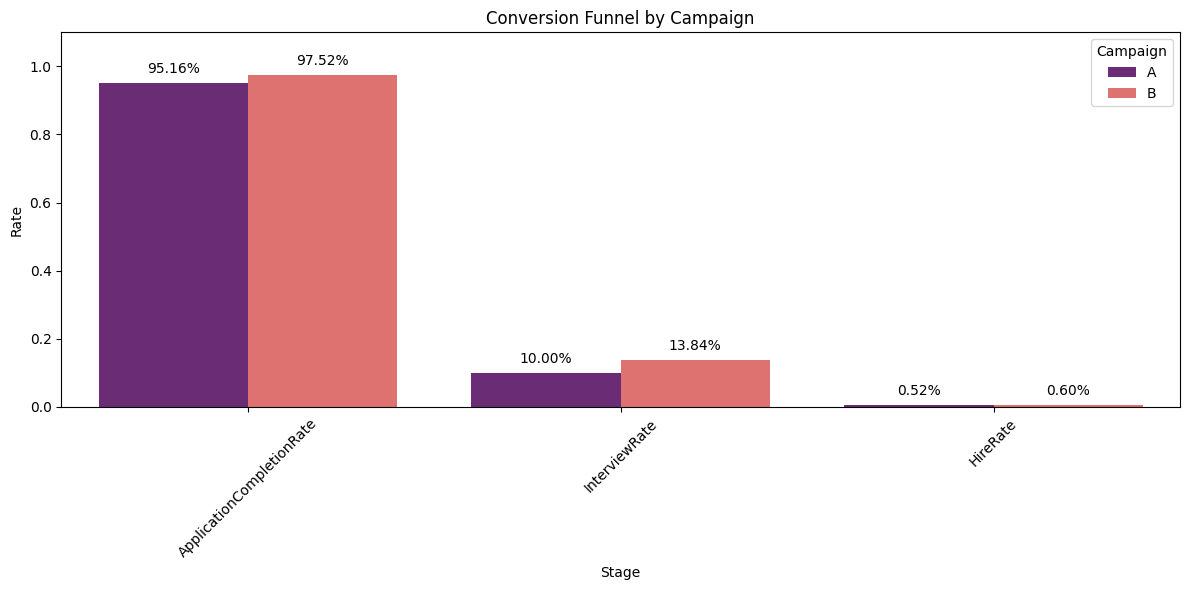

In [27]:
# Conversion funnel
funnel_data = conversion_rates.copy()
funnel_data['InterviewRate'] = interview_rates['InterviewRate']
funnel_data['ApplicationCompletionRate'] = application_completion['CompletionRate']

# Melt for seaborn
funnel_melted = funnel_data.reset_index().melt(id_vars='Campaign',
                                               value_vars=['ApplicationCompletionRate', 'InterviewRate', 'HireRate'],
                                               var_name='Stage',
                                               value_name='Rate')

# Sort 'Stage' for consistent ordering in the plot
stage_order = ['ApplicationCompletionRate', 'InterviewRate', 'HireRate']

plt.figure(figsize=(12,6))
ax = sns.barplot(x='Stage', y='Rate', hue='Campaign', data=funnel_melted, palette='magma', order=stage_order)
plt.title('Conversion Funnel by Campaign')
plt.ylabel('Rate')
plt.xlabel('Stage')
plt.ylim(0, 1.1)

# Annotate each bar with the corresponding Rate
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.2%}",
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    color='black',
                    xytext=(0, 5),
                    textcoords='offset points')

plt.legend(title='Campaign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

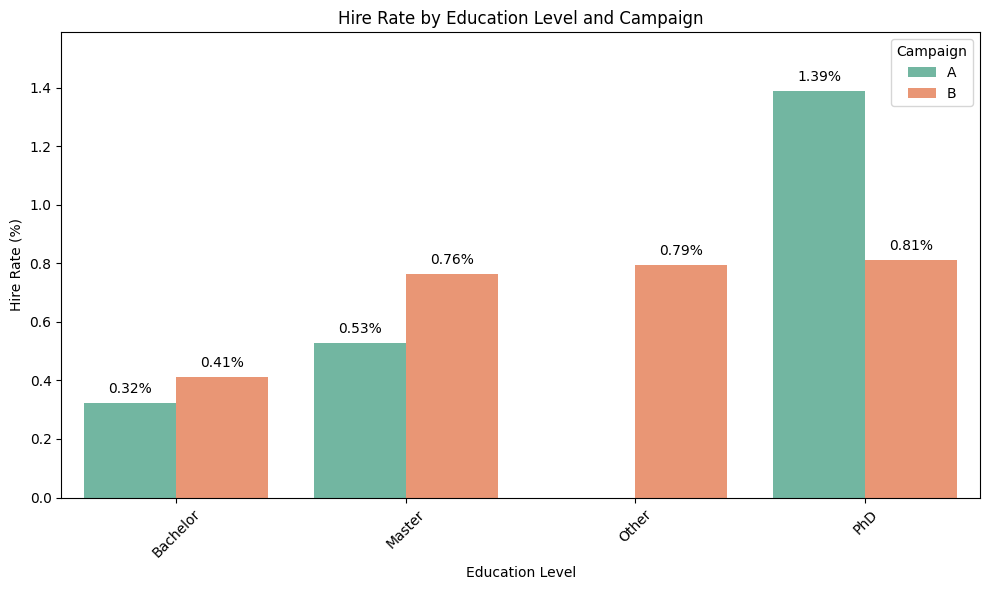

In [28]:
# Aggregate hire rates by Education Level and Campaign
education_hire = df.groupby(['EducationLevel', 'Campaign'])['Hired'].mean().reset_index()
education_hire.rename(columns={'Hired': 'HireRate'}, inplace=True)

# Convert HireRate to percentage for both plotting and annotations
education_hire['HireRate'] *= 100

# Determine the maximum HireRate to set y-axis limit
max_hire_rate = education_hire['HireRate'].max()
y_upper_limit = max_hire_rate + 0.20  # Adding buffer

# Hire Rate by Education Level and Campaign using aggregated data
plt.figure(figsize=(10,6))
ax = sns.barplot(x='EducationLevel', y='HireRate', hue='Campaign', data=education_hire, palette='Set2')
plt.title('Hire Rate by Education Level and Campaign')
plt.ylabel('Hire Rate (%)')
plt.xlabel('Education Level')
plt.ylim(0, y_upper_limit)

# Annotate each bar with the corresponding HireRate
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.2f}%",
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

plt.legend(title='Campaign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

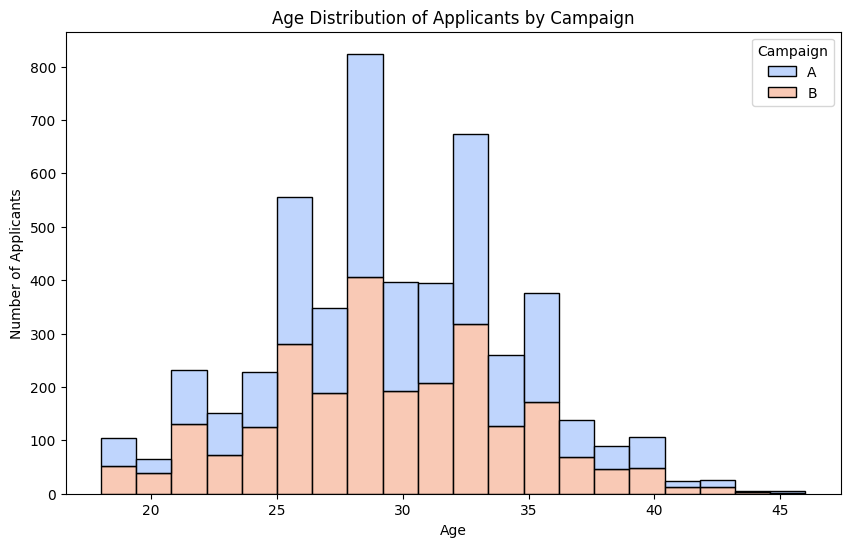

In [29]:
# Age distribution by Campaign
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='Campaign', multiple='stack', palette='coolwarm', bins=20)
plt.title('Age Distribution of Applicants by Campaign')
plt.xlabel('Age')
plt.ylabel('Number of Applicants')
plt.show()

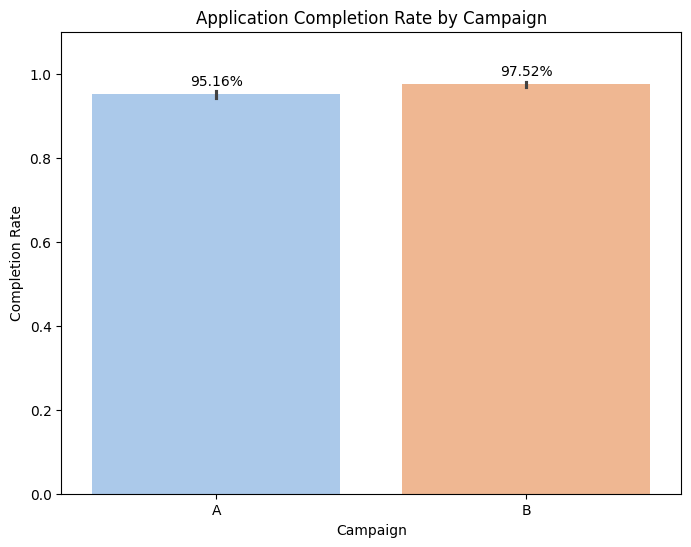

In [30]:
# Application Completion Rate by Campaign
plt.figure(figsize=(8,6))
sns.barplot(x='Campaign', y='ApplicationCompleted', data=df, palette='pastel')
plt.title('Application Completion Rate by Campaign')
plt.ylabel('Completion Rate')
plt.xlabel('Campaign')
completion_rates = df.groupby('Campaign')['ApplicationCompleted'].mean()
for idx, row in completion_rates.items():
    plt.text(x='A' if idx=='A' else 'B', y=row + 0.02, s=f"{row:.2%}", ha='center')
plt.ylim(0, 1.1)
plt.show()